# JAX

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [3]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [4]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)

In [5]:
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))

# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


In [6]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [7]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [8]:
import time

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 5.04 sec
Training set accuracy 0.8339166641235352
Test set accuracy 0.8326999545097351
Epoch 1 in 4.60 sec
Training set accuracy 0.9026666879653931
Test set accuracy 0.896399974822998
Epoch 2 in 5.23 sec
Training set accuracy 0.8711333274841309
Test set accuracy 0.863599956035614
Epoch 3 in 4.97 sec
Training set accuracy 0.8741333484649658
Test set accuracy 0.8657999634742737
Epoch 4 in 4.86 sec
Training set accuracy 0.9073500037193298
Test set accuracy 0.8989999890327454
Epoch 5 in 5.00 sec
Training set accuracy 0.8735166788101196
Test set accuracy 0.8675999641418457
Epoch 6 in 5.21 sec
Training set accuracy 0.9021166563034058
Test set accuracy 0.8973000049591064
Epoch 7 in 4.62 sec
Training set accuracy 0.9048666954040527
Test set accuracy 0.8946999907493591
Epoch 8 in 4.60 sec
Training set accuracy 0.9014500379562378
Test set accuracy 0.8938999772071838
Epoch 9 in 5.22 sec
Training set accuracy 0.8888000249862671
Test set accuracy 0.8817999958992004


# TensorFlow

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


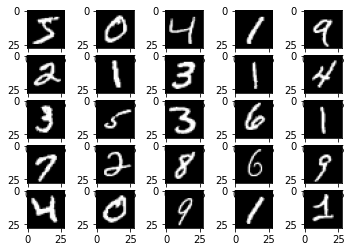

In [9]:
import tensorflow
# example of loading and plotting the mnist dataset
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
# load dataset
(trainX, trainy), (testX, testy) = load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [10]:
# example of a cnn for image classification
from numpy import asarray
from numpy import unique
from numpy import argmax
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [11]:
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()
# reshape data to have a single channel
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
# determine the shape of the input images
in_shape = x_train.shape[1:]
# determine the number of classes
n_classes = len(unique(y_train))
print(in_shape, n_classes)
# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

(28, 28, 1) 10


In [16]:
# define model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
#model.add(MaxPool2D((2, 2)))
model.add(Flatten())
#model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
#model.add(Dense(n_classes, activation='softmax'))
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
%%timeit -r1 -n1

# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=0)
# evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)
# make a prediction
#image = x_train[0]
#yhat = model.predict(asarray([image]))
#print('Predicted: class=%d' % argmax(yhat))

Accuracy: 0.098
7min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# PyTorch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np

In [19]:
(X_trainval, y_trainval), (X_test, y_test) = load_data()

In [20]:
X_trainval = X_trainval.reshape((60000,28*28))

In [21]:
X_test = X_test.reshape((10000,28*28))

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=1)

In [23]:
def get_class_distribution(obj):
    count_dict = dict(zip(list(map(str, range(10))), [0] * 10))
    
    for i in obj:
        if str(i) in count_dict.keys():
            count_dict[str(i)] += 1
        else:
            print("Check classes.")
            
    return count_dict

In [24]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [25]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [26]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002])


In [27]:
class_weights_all = np.repeat(0.0005,len(target_list))
class_count

[5331, 6068, 5362, 5518, 5258, 4879, 5326, 5638, 5266, 5354]

In [28]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [29]:
EPOCHS = 10
BATCH_SIZE = 128 
LEARNING_RATE = 0.01
NUM_FEATURES = 28*28
NUM_CLASSES = 10

In [30]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

train_loader

In [37]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        #x = self.layer_2(x)
        #x = self.batchnorm2(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        
        #x = self.layer_3(x)
        #x = self.batchnorm3(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [40]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [41]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [42]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.23037 | Val Loss: 0.13661 | Train Acc: 99.763| Val Acc: 96.083
Epoch 002: | Train Loss: 0.10448 | Val Loss: 0.10627 | Train Acc: 100.000| Val Acc: 96.783
Epoch 003: | Train Loss: 0.07163 | Val Loss: 0.11017 | Train Acc: 100.000| Val Acc: 96.867
Epoch 004: | Train Loss: 0.06110 | Val Loss: 0.10572 | Train Acc: 100.000| Val Acc: 97.117
Epoch 005: | Train Loss: 0.04982 | Val Loss: 0.09784 | Train Acc: 100.000| Val Acc: 97.100
Epoch 006: | Train Loss: 0.04427 | Val Loss: 0.08903 | Train Acc: 100.000| Val Acc: 97.550
Epoch 007: | Train Loss: 0.03914 | Val Loss: 0.09917 | Train Acc: 100.000| Val Acc: 97.583
Epoch 008: | Train Loss: 0.03573 | Val Loss: 0.10245 | Train Acc: 100.000| Val Acc: 97.500
Epoch 009: | Train Loss: 0.03312 | Val Loss: 0.10852 | Train Acc: 100.000| Val Acc: 97.317
Epoch 010: | Train Loss: 0.02847 | Val Loss: 0.10013 | Train Acc: 100.000| Val Acc: 97.633


Reference:

https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html

https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/


I adapted the code from https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab and made some changes.